## Введение в DS на УБ и МиРА (2022)
### Домашнее задание #5:  Ближайшие соседи
Дедлайн: 19 июня 2022 года, 23:59
Правила игры

Домашнее задание состоит из двух частей, которые оцениваются в 3 - 7 балла. Все пункты в пределах одной части имеют одинаковый вес.

Решения принимаются до 19 июня 2022 года, 23:59 МСК включительно. Работы, отправленные после дедлайна, не проверяются. Дата и время сдачи определяются по последнему запушенному в репозиторий коммиту (можно увидеть на GitHub, наведя мышкой на указатель срока (например, 3 days ago) справа от файлов).

Все решения нужно загрузить в личный репозиторий на GitHub Classroom.

Разрешается использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания. Разрешается использовать любые свободные источники с указанием ссылки на них.

Плагиат не допускается. При обнаружении случаев списывания, 
0
 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.


 ---

В этом задании будем предсказывать удовлетворенность студентов их программой (`LikeDegree`). Скачайте  Student_Behaviour.csv, содержащую информацию о студентов бакалавриата.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import itertools

### Часть 1: Исследуем данные
**Задание 1.** Загрузите данные из файла Student_Behaviour.csv. Выведите первые 5 строк таблицы.

In [2]:
df = pd.read_csv('Student_Behaviour.csv')
df.head(5)

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


**Задание 2.** Проверьте колонки на наличие пропусков, избавьтесь их. 

In [3]:
df.isna().sum(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CertificationCourses  235 non-null    object 
 1   Gender                235 non-null    object 
 2   Department            235 non-null    object 
 3   Height(CM)            235 non-null    float64
 4   Weight(KG)            235 non-null    float64
 5   10Mark                235 non-null    float64
 6   12Mark                235 non-null    float64
 7   CollegeMark           235 non-null    float64
 8   Hobbies               235 non-null    object 
 9   DailyStudingTime      235 non-null    object 
 10  PreferToStudyIn       235 non-null    object 
 11  SalaryExpectation     235 non-null    int64  
 12  LikeDegree            235 non-null    object 
 13  CareerBasedonDegree   235 non-null    object 
 14  GamesSpendingTime     235 non-null    object 
 15  TravellingTime        2

(CertificationCourses    0
 Gender                  0
 Department              0
 Height(CM)              0
 Weight(KG)              0
 10Mark                  0
 12Mark                  0
 CollegeMark             0
 Hobbies                 0
 DailyStudingTime        0
 PreferToStudyIn         0
 SalaryExpectation       0
 LikeDegree              0
 CareerBasedonDegree     0
 GamesSpendingTime       0
 TravellingTime          0
 StressLevel             0
 FinancialStatus         0
 PartTimeJob?            0
 dtype: int64,
 None)

**Задание 3.**  Колонку `CareerBasedonDegree` приведите к числовому виду.

In [4]:
df['CareerBasedonDegree'] = df['CareerBasedonDegree'].str.replace('%', '').astype(float)
df.CareerBasedonDegree

0      50.0
1      75.0
2      50.0
3      50.0
4      25.0
       ... 
230    50.0
231    75.0
232    50.0
233    75.0
234    75.0
Name: CareerBasedonDegree, Length: 235, dtype: float64

**Задание 4.**  В датасете есть 3 поля, с суффиксом `Time`, данные в них строковые, которые означают временной интервал. Извлеките минимальное время(левую границу интервала) для каждой из этих переменных и переведите в минуты, запишите в новые столбцы, удалите старые.

In [5]:
df.columns = df.columns.str.replace(' ', '')  # Есть хитрые проблемы, которые не дают обратиться к полям далее

In [6]:
df.head(100)

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.00,80.0,Video Games,0 - 30 minute,Morning,40000,No,50.0,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.00,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75.0,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.00,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50.0,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.00,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50.0,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.00,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25.0,1.30 - 2 hour,30 - 60 minutes,Good,good,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Yes,Male,BCA,180.0,80.0,91.0,73.30,85.0,Sports,30 - 60 minute,Morning,25000,Yes,100.0,30 - 60 Minute,0 - 30 minutes,Good,good,No
96,Yes,Female,BCA,4.5,42.0,85.0,90.00,85.0,Cinema,30 - 60 minute,Anytime,20000,Yes,100.0,1 - 1.30 hour,30 - 60 minutes,Good,Awful,No
97,Yes,Male,BCA,170.0,70.0,80.0,60.00,80.0,Sports,2 - 3 hour,Night,25000,Yes,75.0,30 - 60 Minute,1 - 1.30 hour,Good,good,No
98,No,Male,BCA,178.0,83.0,85.8,63.66,80.0,Sports,0 - 30 minute,Anytime,20000,Yes,75.0,1.30 - 2 hour,0 - 30 minutes,Good,good,No


Напряжно, что данные в ответах не в одной системе измерений, придется распарсить по словам

In [7]:
df['DailyStudingTime'].explode().dropna().value_counts() 

30 - 60 minute      81
1 - 2 Hour          61
0 - 30 minute       46
2 - 3 hour          24
3 - 4 hour          15
More Than 4 hour     8
Name: DailyStudingTime, dtype: int64

In [8]:
dict1 = {'30 - 60 minute': '30', '1 - 2 Hour': '60', '0 - 30 minute': '0',
         '2 - 3 hour': '120', '3 - 4 hour': '180', 'More Than 4 hour': '240'}

df["DailyStudingTime"] = df["DailyStudingTime"].map(dict1).astype(float)
# df.dropna(inplace=True) 

In [9]:
df['GamesSpendingTime'].explode().dropna().value_counts() 

30 - 60 Minute      69
1 - 1.30 hour       55
1 - 30 Minute       47
More than 2 hour    32
1.30 - 2 hour       27
0 Minute             5
Name: GamesSpendingTime, dtype: int64

In [10]:
dict2 = {'30 - 60 Minute': '30', '1 - 1.30 hour': '60', '1 - 30 Minute': '1',
         'More than 2 hour': '120', '1.30 - 2 hour': '90', '0 Minute': '0'}

df["GamesSpendingTime"] = df["GamesSpendingTime"].map(dict2).astype(float)

In [11]:
df['TravellingTime'].explode().dropna().value_counts() 

30 - 60 minutes     80
0 - 30 minutes      55
1 - 1.30 hour       51
1.30 - 2 hour       18
2 - 2.30 hour       14
more than 3 hour    10
2.30 - 3 hour        7
Name: TravellingTime, dtype: int64

In [12]:
dict3 = {'30 - 60 minutes': '30', '0 - 30 minutes': '0', '1 - 1.30 hour': '60',
         '1.30 - 2 hour': '90', '2 - 2.30 hour': '120', 'more than 3 hour': '180',
        '2.30 - 3 hour': '150'}

df["TravellingTime"] = df["TravellingTime"].map(dict3).astype(float)

In [13]:
df.head(5)

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.0,80.0,Video Games,0.0,Morning,40000,No,50.0,90.0,30.0,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30.0,Morning,15000,Yes,75.0,60.0,0.0,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.0,55.0,Cinema,60.0,Anytime,13000,Yes,50.0,120.0,30.0,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,60.0,Anytime,1500000,No,50.0,90.0,0.0,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30.0,Morning,50000,Yes,25.0,90.0,30.0,Good,good,No


**Задание 5.**  Выбрете колонки (непрерывные переменные), которые будете использовать для предсказания целевой переменной с помощью knn

In [14]:
df.describe()

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,2.350000e+02,235.000000,235.000000,235.000000
mean,157.402128,60.803830,76.842128,68.780128,70.660553,57.829787,3.248168e+04,69.574468,49.731915,49.404255
std,21.510805,14.895844,13.050800,11.016533,15.727446,58.433730,1.113146e+05,21.178671,39.137611,46.726911
min,4.500000,20.000000,7.400000,45.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,152.000000,50.000000,70.000000,60.000000,60.000000,30.000000,1.500000e+04,50.000000,30.000000,30.000000
50%,160.000000,60.000000,80.000000,69.000000,70.000000,30.000000,2.000000e+04,75.000000,30.000000,30.000000
75%,170.000000,70.000000,86.250000,76.000000,80.000000,60.000000,2.500000e+04,75.000000,75.000000,60.000000
max,192.000000,106.000000,98.000000,94.000000,100.000000,240.000000,1.500000e+06,100.000000,120.000000,180.000000


In [15]:
new_col = ['Height(CM)', 'Weight(KG)', '10Mark', '12Mark', 
           'CollegeMark', 'DailyStudingTime', 'SalaryExpectation',
           'CareerBasedonDegree', 'GamesSpendingTime', 'TravellingTime']
df_feat = df[new_col]

**Задание 6.**  Есть ли в выбранных колонках выбросы? (Пока не нужно их чистить)

array([[<AxesSubplot:title={'center':'Height(CM)'}>,
        <AxesSubplot:title={'center':'Weight(KG)'}>,
        <AxesSubplot:title={'center':'10Mark'}>,
        <AxesSubplot:title={'center':'12Mark'}>],
       [<AxesSubplot:title={'center':'CollegeMark'}>,
        <AxesSubplot:title={'center':'DailyStudingTime'}>,
        <AxesSubplot:title={'center':'SalaryExpectation'}>,
        <AxesSubplot:title={'center':'CareerBasedonDegree'}>],
       [<AxesSubplot:title={'center':'GamesSpendingTime'}>,
        <AxesSubplot:title={'center':'TravellingTime'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

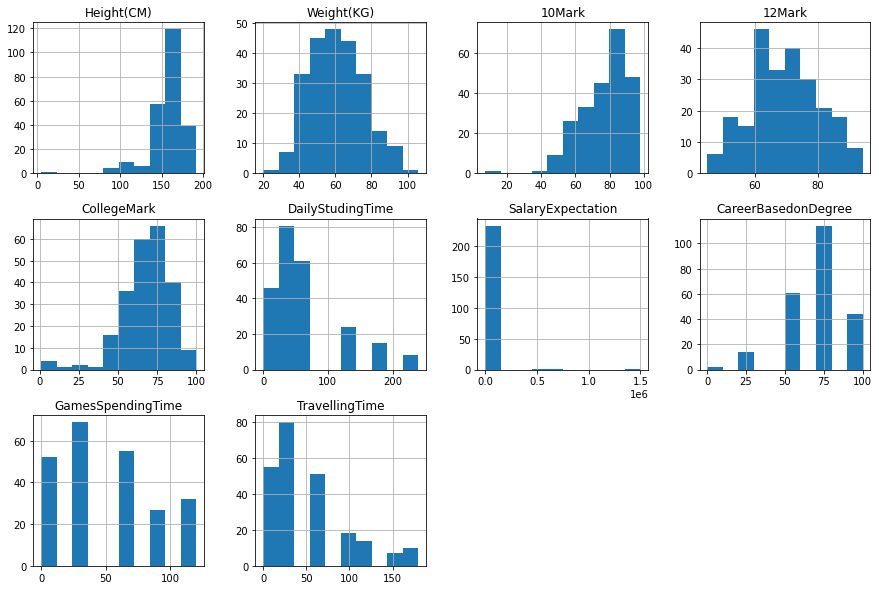

In [16]:
df_feat.hist(figsize=(15,10), layout = (3,4))

In [17]:
df_feat.describe()

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,2.350000e+02,235.000000,235.000000,235.000000
mean,157.402128,60.803830,76.842128,68.780128,70.660553,57.829787,3.248168e+04,69.574468,49.731915,49.404255
std,21.510805,14.895844,13.050800,11.016533,15.727446,58.433730,1.113146e+05,21.178671,39.137611,46.726911
min,4.500000,20.000000,7.400000,45.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,152.000000,50.000000,70.000000,60.000000,60.000000,30.000000,1.500000e+04,50.000000,30.000000,30.000000
50%,160.000000,60.000000,80.000000,69.000000,70.000000,30.000000,2.000000e+04,75.000000,30.000000,30.000000
75%,170.000000,70.000000,86.250000,76.000000,80.000000,60.000000,2.500000e+04,75.000000,75.000000,60.000000
max,192.000000,106.000000,98.000000,94.000000,100.000000,240.000000,1.500000e+06,100.000000,120.000000,180.000000


In [18]:
df_feat.quantile(0.99)

Height(CM)                190.000
Weight(KG)                 92.660
10Mark                     95.864
12Mark                     90.660
CollegeMark                96.320
DailyStudingTime          240.000
SalaryExpectation      370800.000
CareerBasedonDegree       100.000
GamesSpendingTime         120.000
TravellingTime            180.000
Name: 0.99, dtype: float64

In [19]:
df_feat.quantile(0.01)

Height(CM)             90.00
Weight(KG)             33.00
10Mark                 45.00
12Mark                 47.34
CollegeMark             4.53
DailyStudingTime        0.00
SalaryExpectation      11.70
CareerBasedonDegree    25.00
GamesSpendingTime       0.00
TravellingTime          0.00
Name: 0.01, dtype: float64

In [20]:
# df_outliers = df_feat[(df_feat > df_feat.quantile(0.95)) |
#                  (df_feat < df_feat.quantile(0.05))]
# df_outliers.dropna(inplace=True)
# df_outliers

In [21]:
df_feat[(np.abs(stats.zscore(df_feat)) < 3).all(axis=1)]

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,100.0,58.0,79.0,65.00,80.0,0.0,40000,50.0,90.0,30.0
2,159.0,78.0,69.5,61.00,55.0,60.0,13000,50.0,120.0,30.0
4,170.0,54.0,40.0,65.00,30.0,30.0,50000,25.0,90.0,30.0
5,139.0,33.0,90.0,75.00,70.0,30.0,20000,50.0,30.0,0.0
7,152.0,43.0,61.6,61.67,75.0,60.0,25000,50.0,60.0,60.0
...,...,...,...,...,...,...,...,...,...,...
230,170.0,76.0,72.0,67.00,65.0,30.0,7000,50.0,120.0,30.0
231,172.0,52.0,72.0,70.00,76.0,120.0,25000,75.0,30.0,30.0
232,139.0,33.0,90.0,75.00,70.0,30.0,20000,50.0,30.0,150.0
233,153.0,58.0,85.0,74.00,75.0,0.0,20000,75.0,120.0,150.0


как видно немного выбросов все же имеется, 235 - 215 = 20

**Задание 7.**  Как распределена целевая переменная? Нет ли дисбаланса классов? Если есть дисбаланс, какие метрики качества классификатора можно использовать, какие нет? Рассматриваем метрики, которые проходили в рамках курса.

<AxesSubplot:>

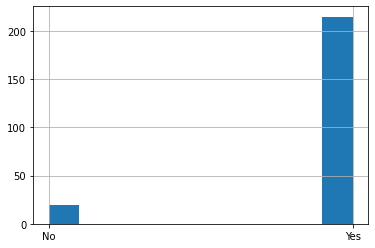

In [22]:
df.LikeDegree.hist()

https://github.com/V-Marco/public_intro_to_DS_mba_hse/blob/main/seminars/week12%20-%20knn/sem12_classification.ipynb

дисбаланс классов очевиден, желательно использовать:
Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту.
1. Точность (precision):
Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку.
2. Полнота (Recall): 
Показывает, как много объектов первого класса наш алгоритм находит.

**Задание 8.**  Переведите целевую переменную к численному формату.

In [23]:
# df1 = pd.get_dummies(df['LikeDegree'])
dict1 = {'Yes': '1', 'No': '0'}

df["LikeDegree"] = df["LikeDegree"].map(dict1).astype(float)

In [24]:
df

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.0,80.0,Video Games,0.0,Morning,40000,0.0,50.0,90.0,30.0,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30.0,Morning,15000,1.0,75.0,60.0,0.0,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.0,55.0,Cinema,60.0,Anytime,13000,1.0,50.0,120.0,30.0,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,60.0,Anytime,1500000,0.0,50.0,90.0,0.0,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30.0,Morning,50000,1.0,25.0,90.0,30.0,Good,good,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,Yes,Male,B.com ISM,170.0,76.0,72.0,67.0,65.0,Video Games,30.0,Morning,7000,1.0,50.0,120.0,30.0,Bad,Bad,No
231,Yes,Male,B.com ISM,172.0,52.0,72.0,70.0,76.0,Cinema,120.0,Anytime,25000,1.0,75.0,30.0,30.0,Good,good,No
232,Yes,Female,BCA,139.0,33.0,90.0,75.0,70.0,Cinema,30.0,Night,20000,1.0,50.0,30.0,150.0,Bad,good,No
233,Yes,Female,Commerce,153.0,58.0,85.0,74.0,75.0,Cinema,0.0,Anytime,20000,1.0,75.0,120.0,150.0,Awful,good,No


### Часть 2: Строим модели
**Задание 1.** Разбейте выборку на обучающую и тестовую. 

In [25]:
y = df["LikeDegree"]
X = df_feat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Задание 2.** Постройте наивную модель предсказания для целевой переменной. Наивная модель - это самая простая модель, без сложных зависимостей. Например, для регрессии наивная модель - среднее для целевой переменной (см. семинар 11). В данном случае наивной моделью может быть предположение "все студенты (не)довольны".

In [26]:
model = DummyClassifier(strategy='prior')
model.fit(X, y)
yhat = model.predict(X)

In [27]:
all_metrics = pd.DataFrame(index=['Nearest_Neighbors_3', 'Nearest_Neighbors_5', 'Nearest_Neighbors_7', 'Naive',
                                 'Nearest_Neighbors_3_scaled', 'Nearest_Neighbors_5_scaled', 'Nearest_Neighbors_7_scaled',
                                 'NN_3_prepoc','NN_5_prepoc','NN_7_prepoc', 'NN_7_prepoc_scaled'],
                      columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [28]:
all_metrics.iloc[3, 0] = metrics.accuracy_score(y, yhat)
all_metrics.iloc[3, 1] = metrics.precision_score(y, yhat)
all_metrics.iloc[3, 2] = metrics.recall_score(y, yhat)
all_metrics.iloc[3, 3] = metrics.f1_score(y, yhat)

**Задание 3.** Постройте модели ближайших соседей для 3, 5, 7 ближайших соседей. 

можно удалить явно коррелирующие признаки, так как вклад в алгоритм у них повторяющийся

In [29]:
corr_matrix = df_feat.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(10)

10Mark            12Mark                 0.473618
                  CollegeMark            0.466234
12Mark            CollegeMark            0.425123
Height(CM)        Weight(KG)             0.275948
DailyStudingTime  CareerBasedonDegree    0.262384
CollegeMark       CareerBasedonDegree    0.203160
Height(CM)        TravellingTime         0.142075
                  12Mark                 0.120672
Weight(KG)        GamesSpendingTime      0.117276
CollegeMark       SalaryExpectation      0.103034
dtype: float64

не понадобилось, все норм

In [30]:
# corr_mx = np.corrcoef(X_train.T)
# corr_i = np.where(corr_mx > 0.95)
# for i in range(len(new_col)):
#     if corr_i[0][i] != corr_i[1][i]:
#         selected.pop(corr_i[0][i])

In [31]:
%%time

n_3 = KNeighborsClassifier(n_neighbors=3)
n_3.fit(X_train, y_train)

prediction = n_3.predict(X_test)
(prediction == y_test).mean()

Wall time: 40 ms


0.9014084507042254

In [32]:
all_metrics.iloc[0, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[0, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[0, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[0, 3] = metrics.f1_score(y_test, prediction)

In [33]:
%%time

n_5 = KNeighborsClassifier(n_neighbors=5)
n_5.fit(X_train, y_train)

prediction = n_5.predict(X_test)
(prediction == y_test).mean()

Wall time: 46 ms


0.9154929577464789

In [34]:
all_metrics.iloc[1, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[1, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[1, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[1, 3] = metrics.f1_score(y_test, prediction)

In [35]:
%%time

n_7 = KNeighborsClassifier(n_neighbors=7)
n_7.fit(X_train, y_train)

prediction = n_7.predict(X_test)
(prediction == y_test).mean()

Wall time: 34 ms


0.9154929577464789

In [36]:
all_metrics.iloc[2, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[2, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[2, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[2, 3] = metrics.f1_score(y_test, prediction)

**Задание 4.** Постройте метрики качества на тестовой выборке (3 известных вам) для моделей из 1 и 2 задания и сравните между собой. Какая победила? 

In [37]:
all_metrics.astype('float').round(3)

,Accuracy,Precision,Recall,F1
Nearest_Neighbors_3,0.901,0.914,0.985,0.948
Nearest_Neighbors_5,0.915,0.915,1.000,0.956
Nearest_Neighbors_7,0.915,0.915,1.000,0.956
Naive,0.915,0.915,1.000,0.956
Nearest_Neighbors_3_scaled,NaN,NaN,NaN,NaN
Nearest_Neighbors_5_scaled,NaN,NaN,NaN,NaN
Nearest_Neighbors_7_scaled,NaN,NaN,NaN,NaN
NN_3_prepoc,NaN,NaN,NaN,NaN
NN_5_prepoc,NaN,NaN,NaN,NaN
NN_7_prepoc,NaN,NaN,NaN,NaN


для 5 и 7 соседей разницы нет

**Задание 5.** Примените шкалирование (MinMax, обучите его на обучающей выборке к факторам, затем примените к тестовой), снова постройте модели для нескольких вариантов соседей (3, 5, 7). Помогло ли шкалирование? 

In [38]:
scaler = MinMaxScaler( )
scaler.fit(X_train) 
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

In [39]:
print(X_train_norm.max(), X_test_norm.max())

1.0000000000000002 1.0425531914893618


In [40]:
%%time

n_3 = KNeighborsClassifier(n_neighbors=3)
n_3.fit(X_train_norm, y_train)

prediction = n_3.predict(X_test_norm)
(prediction == y_test).mean()

Wall time: 27 ms


0.9014084507042254

In [41]:
all_metrics.iloc[4, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[4, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[4, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[4, 3] = metrics.f1_score(y_test, prediction)

In [42]:
%%time

n_5 = KNeighborsClassifier(n_neighbors=5)
n_5.fit(X_train_norm, y_train)

prediction = n_5.predict(X_test_norm)
(prediction == y_test).mean()

Wall time: 32 ms


0.9154929577464789

In [43]:
all_metrics.iloc[5, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[5, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[5, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[5, 3] = metrics.f1_score(y_test, prediction)

In [44]:
%%time

n_7 = KNeighborsClassifier(n_neighbors=7)
n_7.fit(X_train_norm, y_train)

prediction = n_7.predict(X_test_norm)
(prediction == y_test).mean()

Wall time: 30 ms


0.9154929577464789

In [45]:
all_metrics.iloc[6, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[6, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[6, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[6, 3] = metrics.f1_score(y_test, prediction)

In [46]:
all_metrics.astype('float').round(3)

,Accuracy,Precision,Recall,F1
Nearest_Neighbors_3,0.901,0.914,0.985,0.948
Nearest_Neighbors_5,0.915,0.915,1.000,0.956
Nearest_Neighbors_7,0.915,0.915,1.000,0.956
Naive,0.915,0.915,1.000,0.956
Nearest_Neighbors_3_scaled,0.901,0.914,0.985,0.948
Nearest_Neighbors_5_scaled,0.915,0.915,1.000,0.956
Nearest_Neighbors_7_scaled,0.915,0.915,1.000,0.956
NN_3_prepoc,NaN,NaN,NaN,NaN
NN_5_prepoc,NaN,NaN,NaN,NaN
NN_7_prepoc,NaN,NaN,NaN,NaN


Шкалирование помогло только для 3х соседей

**Задание 6.** Избавьтесь от выбросов в исходной выборке, затем снова разделите ее на тестовую и обучающую, постройте модель для нескольких вариантов числа соседей(3, 5, 7). Какое число соседей лучшее и почему? Улучшилось ли качество модели по сравнению со лучшей моделью, в которой было применено шкалирование из задания 5?

In [47]:
new_col1 = ["LikeDegree", 'Height(CM)', 'Weight(KG)', '10Mark', '12Mark', 
           'CollegeMark', 'DailyStudingTime', 'SalaryExpectation',
           'CareerBasedonDegree', 'GamesSpendingTime', 'TravellingTime']
# удаляем выбросы
df_feat = df[new_col1]
df_feat = df_feat[(np.abs(stats.zscore(df_feat[new_col])) < 3).all(axis=1)]

In [48]:
df_feat

,LikeDegree,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,0.0,100.0,58.0,79.0,65.00,80.0,0.0,40000,50.0,90.0,30.0
2,1.0,159.0,78.0,69.5,61.00,55.0,60.0,13000,50.0,120.0,30.0
4,1.0,170.0,54.0,40.0,65.00,30.0,30.0,50000,25.0,90.0,30.0
5,1.0,139.0,33.0,90.0,75.00,70.0,30.0,20000,50.0,30.0,0.0
7,1.0,152.0,43.0,61.6,61.67,75.0,60.0,25000,50.0,60.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...
230,1.0,170.0,76.0,72.0,67.00,65.0,30.0,7000,50.0,120.0,30.0
231,1.0,172.0,52.0,72.0,70.00,76.0,120.0,25000,75.0,30.0,30.0
232,1.0,139.0,33.0,90.0,75.00,70.0,30.0,20000,50.0,30.0,150.0
233,1.0,153.0,58.0,85.0,74.00,75.0,0.0,20000,75.0,120.0,150.0


In [49]:
y = df_feat["LikeDegree"]
X = df_feat.drop('LikeDegree', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
%%time

n_3 = KNeighborsClassifier(n_neighbors=1)
n_3.fit(X_train, y_train)

prediction = n_3.predict(X_test)
(prediction == y_test).mean()

Wall time: 39 ms


0.90625

In [51]:
all_metrics.iloc[7, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[7, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[7, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[7, 3] = metrics.f1_score(y_test, prediction)

In [52]:
%%time

n_5 = KNeighborsClassifier(n_neighbors=5)
n_5.fit(X_train, y_train)

prediction = n_5.predict(X_test)
(prediction == y_test).mean()

Wall time: 33 ms


0.921875

In [53]:
all_metrics.iloc[8, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[8, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[8, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[8, 3] = metrics.f1_score(y_test, prediction)

In [54]:
%%time

n_7 = KNeighborsClassifier(n_neighbors = 7)
n_7.fit(X_train, y_train)

prediction = n_7.predict(X_test)
(prediction == y_test).mean()

Wall time: 33 ms


0.921875

In [55]:
all_metrics.iloc[9, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[9, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[9, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[9, 3] = metrics.f1_score(y_test, prediction)

In [56]:
all_metrics.astype('float').round(3)

,Accuracy,Precision,Recall,F1
Nearest_Neighbors_3,0.901,0.914,0.985,0.948
Nearest_Neighbors_5,0.915,0.915,1.000,0.956
Nearest_Neighbors_7,0.915,0.915,1.000,0.956
Naive,0.915,0.915,1.000,0.956
Nearest_Neighbors_3_scaled,0.901,0.914,0.985,0.948
Nearest_Neighbors_5_scaled,0.915,0.915,1.000,0.956
Nearest_Neighbors_7_scaled,0.915,0.915,1.000,0.956
NN_3_prepoc,0.906,0.921,0.983,0.951
NN_5_prepoc,0.922,0.922,1.000,0.959
NN_7_prepoc,0.922,0.922,1.000,0.959


**Задание 7.** Какая конфигурация модели получилась лучшей? Почему?Выбираем из всех построенных моделей, не забудьте про наивный прогноз и все рассмотренне варианты числа соседей. 

На всякий случай построим еще объединение лучших моделей, scaled + prepoccesed

In [57]:
scaler = MinMaxScaler( )
scaler.fit(X_train) 
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

In [58]:
%%time

n_7 = KNeighborsClassifier(n_neighbors = 7)
n_7.fit(X_train_norm, y_train)

prediction = n_7.predict(X_test_norm)
(prediction == y_test).mean()

Wall time: 36 ms


0.921875

In [64]:
prediction

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [59]:
all_metrics.iloc[10, 0] = metrics.accuracy_score(y_test, prediction)
all_metrics.iloc[10, 1] = metrics.precision_score(y_test, prediction)
all_metrics.iloc[10, 2] = metrics.recall_score(y_test, prediction)
all_metrics.iloc[10, 3] = metrics.f1_score(y_test, prediction)

In [60]:
all_metrics.astype('float').round(3)

,Accuracy,Precision,Recall,F1
Nearest_Neighbors_3,0.901,0.914,0.985,0.948
Nearest_Neighbors_5,0.915,0.915,1.000,0.956
Nearest_Neighbors_7,0.915,0.915,1.000,0.956
Naive,0.915,0.915,1.000,0.956
Nearest_Neighbors_3_scaled,0.901,0.914,0.985,0.948
Nearest_Neighbors_5_scaled,0.915,0.915,1.000,0.956
Nearest_Neighbors_7_scaled,0.915,0.915,1.000,0.956
NN_3_prepoc,0.906,0.921,0.983,0.951
NN_5_prepoc,0.922,0.922,1.000,0.959
NN_7_prepoc,0.922,0.922,1.000,0.959


лучшими вышли модели NN_5_prepoc, NN_7_prepoc, NN_7_prepoc_scaled.
Recall  = 1 демонстрирует способность алгоритма обнаруживать данный класс вообще, 
а высокий Precision — способность отличать этот класс от других классов. F1 ~ 1 указывает на производительность модели бинарной классификации. В общем цифры все хорошие.
Так как внутри метода ближайшего соседа мы измеряем похожесть между объектами с помощью какого-то расстояния, то выбросы увиличивают это расстояние, что логично снижает качество модели, поэтому очистка почти всегда улучшает качество. Это, кстати, недостаток knn. https://towardsdatascience.com/k-nearest-neighbors-94395f445221
Увеличение k после 5 не дает преимуществ, так как классы уже лежат довольно близко, тут подробнее https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb

In [61]:
# https://github.com/V-Marco/public_intro_to_DS_mba_hse/blob/main/seminars/week12%20-%20knn/sem12_classification.ipynb
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

In [62]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_norm, y_train)
p_pred_knn_norm = knn.predict_proba(X_test_norm)[:,-1]
p_pred_knn = knn.predict_proba(X_test)[:,-1]

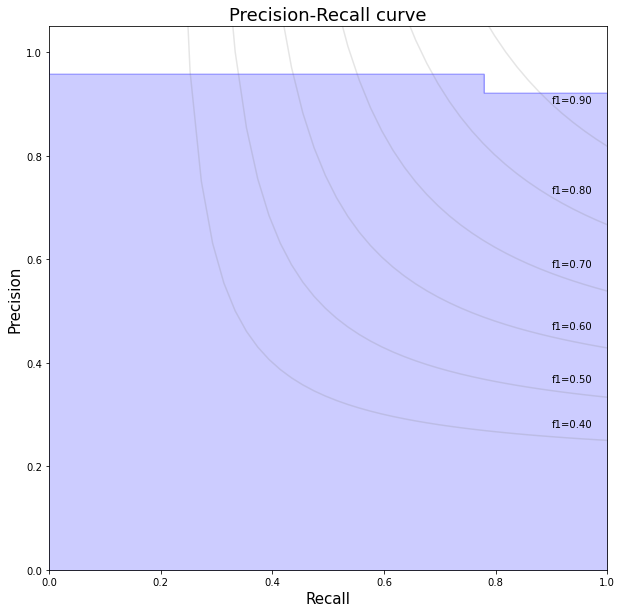

In [63]:
plot_precision_recall_curve(p_pred_knn_norm, y_test)